In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer 
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as ms
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### AdaBoost
- 정의
    - 약한 학습기를 순차적으로 학습시켜 개별 학습기에 가중치를 부여하여 결합한 모델을 생성

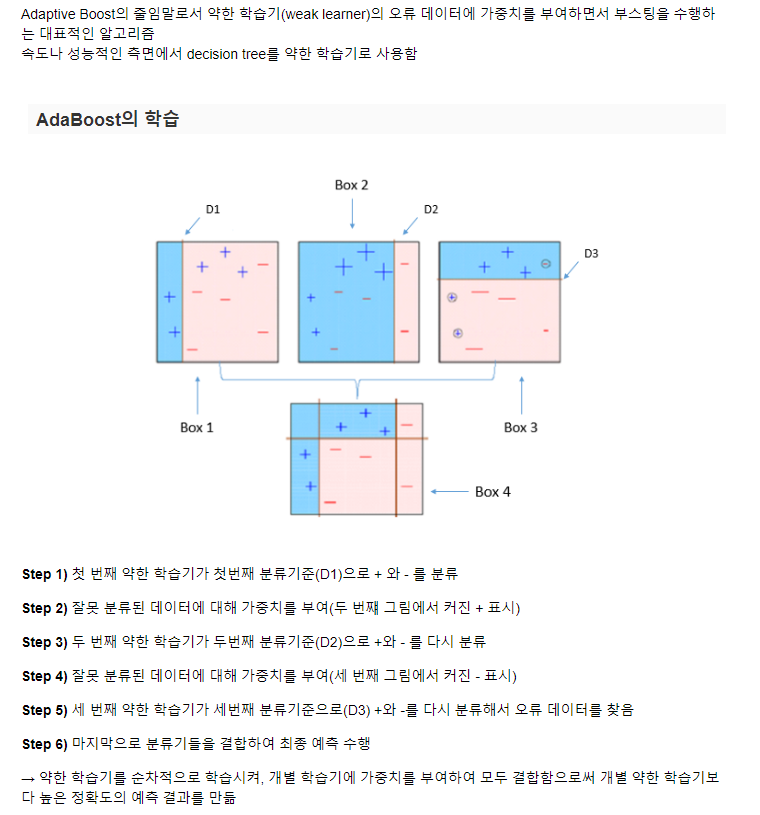

In [13]:
from IPython.display import Image
Image('./images/adaboost-01.png')

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
# HAR 데이터 이용
def human_activity_dataset() :

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('./data/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])
    # display(feature_name_df)

    # 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
    feature_name = feature_name_df.iloc[:, 1].values.tolist()
    # print(feature_name)

    # 중복 피처에 대한 에러처리 구문
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    new_feature_name_df.head()

    X_train=pd.read_csv('./data/train/X_train.txt', sep = '\s+', header = None, names = feature_name)
    X_test = pd.read_csv('./data/test/X_test.txt', sep = '\s+', header = None, names = feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/train/y_train.txt', sep = '\s+', names = ['action'])
    y_test = pd.read_csv('./data/test/y_test.txt', sep = '\s+', names = ['action'])
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = human_activity_dataset()

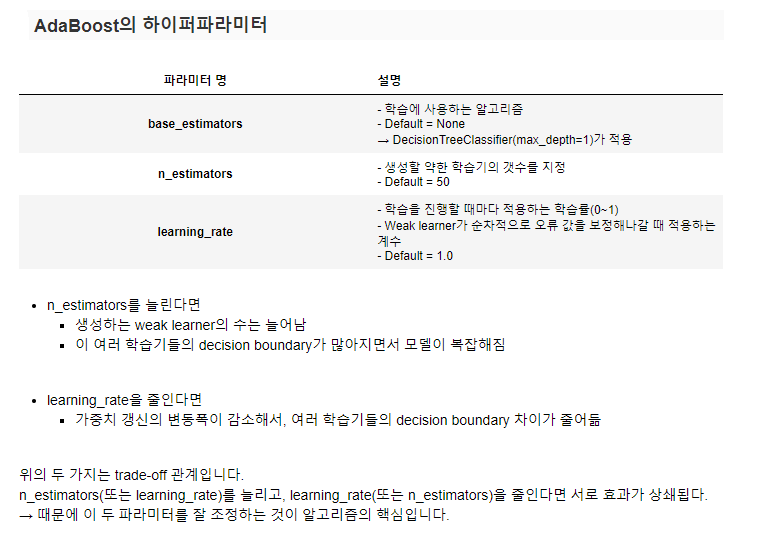

In [14]:
Image('./images/adaboost-02.png')

In [15]:
from sklearn.ensemble import AdaBoostClassifier

In [24]:
ada_model = AdaBoostClassifier(random_state = 0, n_estimators = 60, learning_rate = 0.4)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)

print('예측 정확도 :', accuracy_score(y_test, y_pred))

예측 정확도 : 0.8187987784187309


### GBM

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
import time

In [29]:
start_time = time.time()

gbc_model = GradientBoostingClassifier(random_state = 0)
gbc_model.fit(X_train, y_train)

y_pred = gbc_model.predict(X_test)
print('수행시간 :', time.time() - start_time)

수행시간 : 728.3070669174194


In [30]:
print('정확도 :', accuracy_score(y_test, y_pred))

정확도 : 0.9389209365456397


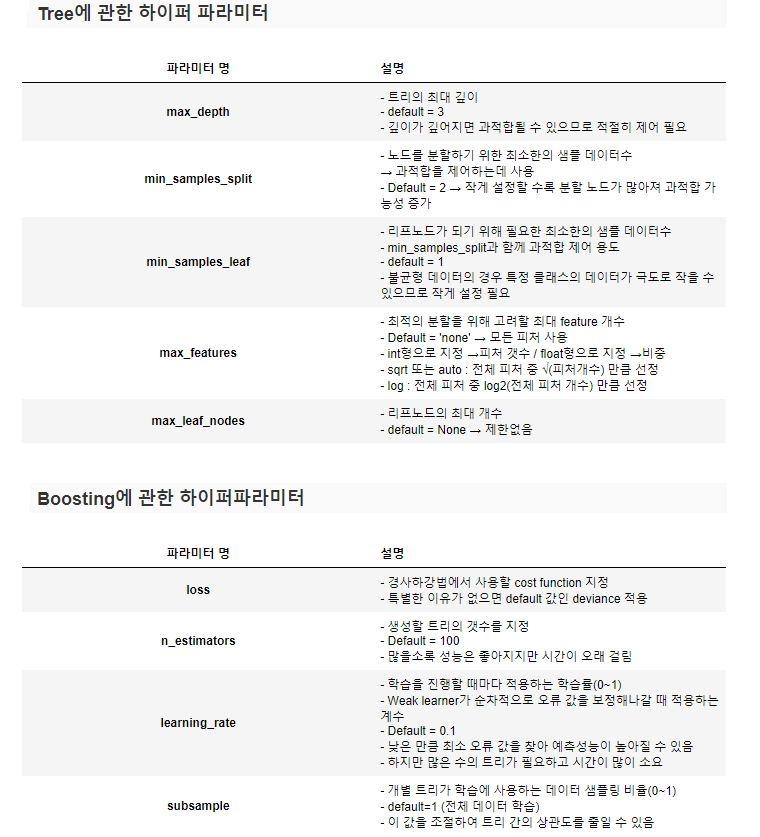

In [31]:
Image('./images/GBM-hyper.png')

In [40]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 확인

def classifier_eval(y_tet, y_pred) :
    print('오차행렬 :', confusion_matrix(y_test, y_pred))
    print('정확도   :', accuracy_score(y_test, y_pred))
    # print('정밀도   :', precision_score(y_test, y_pred))
    # print('재현율   :', recall_score(y_test, y_pred))
    # print('F1       :', f1_score(y_test, y_pred))
    # print('AUC      :', roc_auc_score(y_test, y_pred))

In [36]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 튜닝을 이용한 예측 정확도를 실습
start_time = time.time()

gbc_model = GradientBoostingClassifier(random_state = 0)
params = {
    'n_estimators' : [200],
    'learning_rate' : [0.05, 0.1, 0.15]
}

gbc_gscv_model = GridSearchCV(gbc_model, param_grid = params, cv = 2)
gbc_gscv_model.fit(X_train, y_train)

print('최적의 하이퍼 파라미터 :', gbc_gscv_model.best_params_)
print('예측 정확도 :', gbc_gscv_model.best_score_)
print('수행시간 :', time.time() - start_time)

최적의 하이퍼 파라미터 : {'learning_rate': 0.1, 'n_estimators': 200}
예측 정확도 : 0.8994831338411317
수행시간 : 8706.341685295105


In [41]:
gscv_pred = gbc_gscv_model.best_estimator_.predict(X_test)
classifier_eval(y_test, gscv_pred)

오차행렬 : [[485   9   2   0   0   0]
 [ 18 447   5   0   1   0]
 [  8  25 386   0   1   0]
 [  0   2   0 417  72   0]
 [  0   0   0  35 497   0]
 [  0   0   0   0   0 537]]
정확도   : 0.9395995928062436


In [42]:
# 최적의 하이퍼 파라미터를 이용하여 GradientBoosting을 다시 학습
hyper_gbc_model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 200)
hyper_gbc_model.fit(X_train, y_train)
hyper_y_pred = hyper_gbc_model.predict(X_test)

[1.21482386e-06 1.66495382e-04 8.92052187e-06 4.04208204e-13
 1.86257294e-05 1.30782217e-07 4.98798976e-06 1.33953310e-06
 8.52823752e-06 4.04552027e-02]


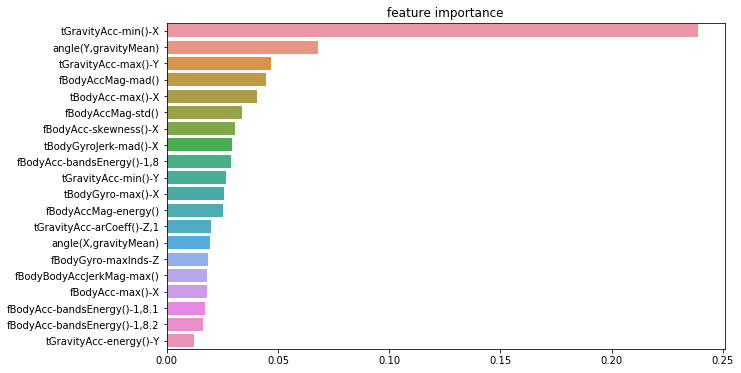

In [43]:
# feature importance 시각화
print(hyper_gbc_model.feature_importances_[:10])

# 피쳐 중요도를 시각화 top20
feature_importances = pd.Series(hyper_gbc_model.feature_importances_, index = X_train.columns)

# feature_importances
feature_top20 = feature_importances.sort_values(ascending = False)[:20]
feature_top20

plt.figure(figsize = (10, 6))
plt.title('feature importance')
sns.barplot(x = feature_top20, y = feature_top20.index)

plt.show()